In [1]:
import pickle
import datetime
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FormatStrFormatter
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

In [2]:
df = pd.read_csv('data/df_out.csv')

## Data Preparation

### Data Cleaning

In [3]:
# Проверяем датасет на отсутствие дублирующих записей

print('Количество дублирующихся записей - ', len(df[df.duplicated()].values)) 

Количество дублирующихся записей -  0


In [4]:
# Выводим информацию о датасете, типах данных и количестве пропусков

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

<AxesSubplot:>

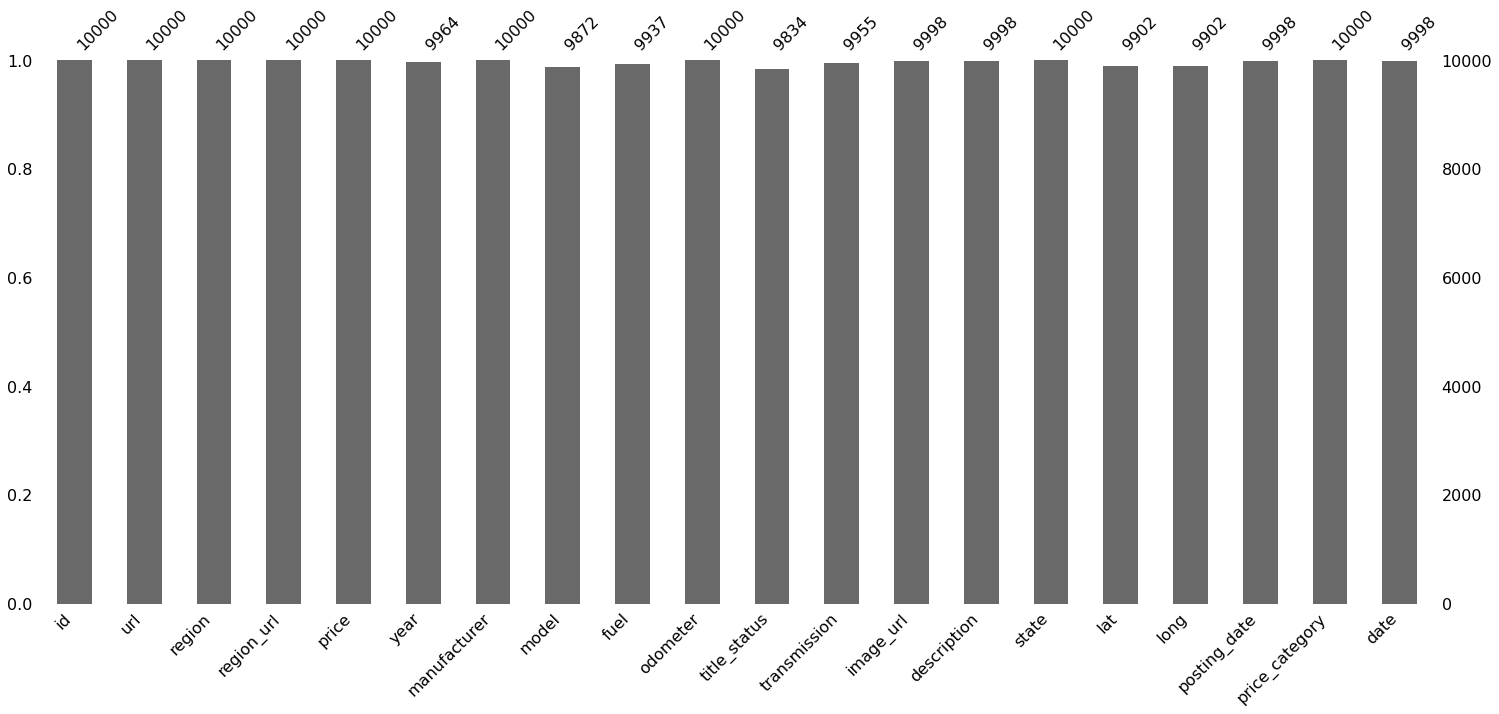

In [5]:
msno.bar(df)

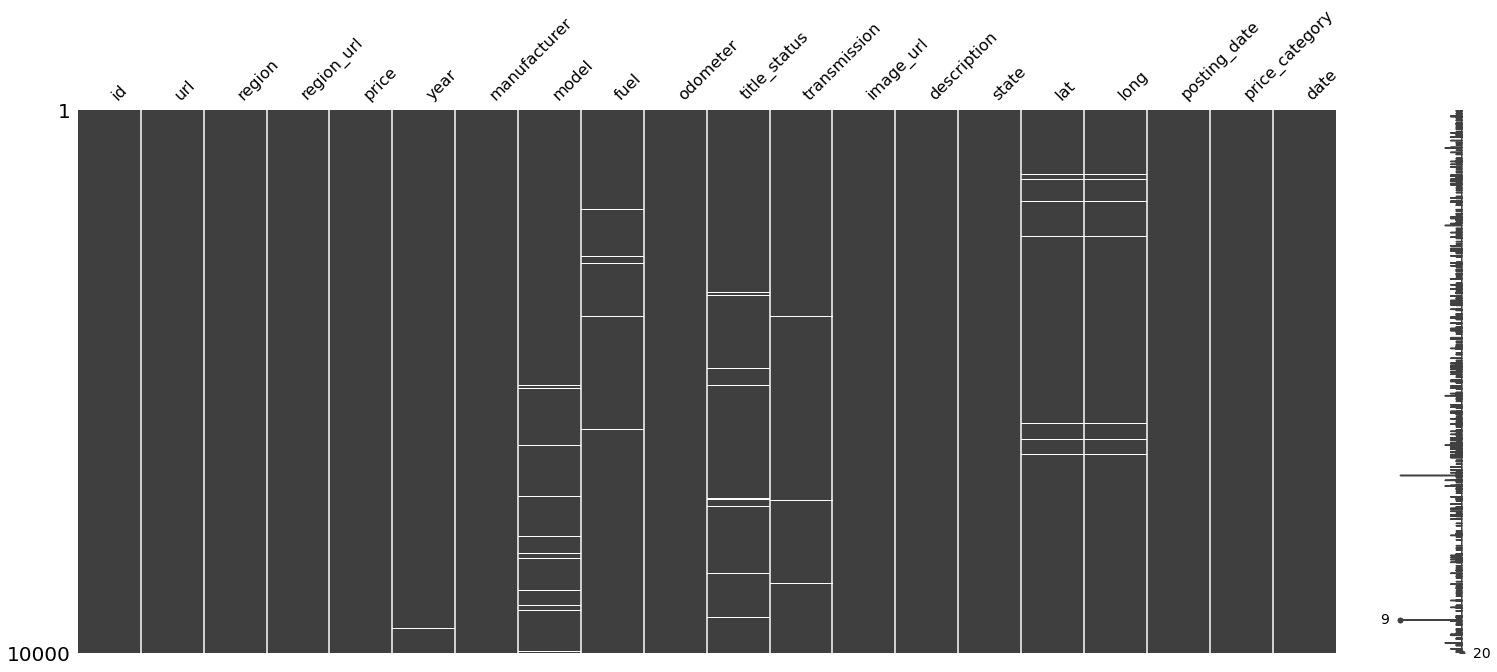

In [6]:
msno.matrix(df);

In [7]:
# Определяем количество полностью заполненных объектов, процент и количество пропущенных значений в признаках:

def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))
print_useful_rows_info(df)
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
print(f'Процент пропущенных значений:\n' + f'{missing_values}')

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки: 95.07
Процент пропущенных значений:
title_status      1.66
model             1.28
long              0.98
lat               0.98
fuel              0.63
transmission      0.45
year              0.36
posting_date      0.02
description       0.02
image_url         0.02
date              0.02
url               0.00
odometer          0.00
manufacturer      0.00
state             0.00
price             0.00
region_url        0.00
region            0.00
price_category    0.00
id                0.00
dtype: float64


In [8]:
print('Пропущенные значения есть в столбцах:')
for i in range(0, len(missing_values)):
    if missing_values[i] > 0:
        print(missing_values.index[i], '-', df.loc[:, missing_values.index[i]].isna().sum())

Пропущенные значения есть в столбцах:
title_status - 166
model - 128
long - 98
lat - 98
fuel - 63
transmission - 45
year - 36
posting_date - 2
description - 2
image_url - 2
date - 2


In [9]:
# Выводим строки с отсутствующими данными о дате размещения

df[df.date.isnull()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
6728,7315259025,https://nh.craigslist.org/cto/d/manchester-201...,new hampshire,https://nh.craigslist.org,3750,NaN,other,NaN,NaN,95674,NaN,NaN,NaN,NaN,nh,NaN,NaN,NaN,low,NaN
9388,7208549803,https://bellingham.craigslist.org/ctd/d/bellin...,bellingham,https://bellingham.craigslist.org,11999,NaN,other,NaN,NaN,95674,NaN,NaN,NaN,NaN,wa,NaN,NaN,NaN,medium,NaN


In [10]:
# Сохраняем в новый датасет без строк с отсутствующей датой, т.к. в них отсутствует информация обо всех основных признаках

df_clean = df.dropna(subset=['date'])
df_clean.shape

(9998, 20)

In [11]:
# Выводим количество пропусков в оставшихся признаках

def missing_values(df):
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    for i in range(0, len(missing_values)):
        if missing_values[i] > 0:
            print(missing_values.index[i], '-', df_clean.loc[:, missing_values.index[i]].isna().sum())
missing_values(df_clean)

title_status - 164
model - 126
long - 96
lat - 96
fuel - 61
transmission - 43
year - 34


In [12]:
# Выводим строки с отсутствующими данными о годе выпуска

df[df.year.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
344,7304102133,https://wenatchee.craigslist.org/ctd/d/wenatch...,wenatchee,https://wenatchee.craigslist.org,35880,NaN,other,500,gas,13508,clean,automatic,https://images.craigslist.org/00J0J_6IMoEUzIIM...,2019 *Ram* *1500* Big Horn/Lone Star 4x2 Quad ...,wa,47.434493,-120.320759,2021-04-09T06:31:03-0700,high,2021-04-09 13:31:03+00:00
420,7316337069,https://lasvegas.craigslist.org/ctd/d/scottsda...,las vegas,https://lasvegas.craigslist.org,84995,NaN,other,Super Duty F-350 SRW,diesel,1268,clean,automatic,https://images.craigslist.org/00x0x_iQCC0Ef28S...,2020 *Ford* *Super Duty F-350 SRW* 1K MILES. B...,nv,33.458277,-111.925970,2021-05-03T11:31:39-0700,high,2021-05-03 18:31:39+00:00
425,7315662117,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,43900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00f0f_7AwipNocNH...,"2019 *Dodge* *Grand Caravan* SE - $43,900Call ...",co,39.674406,-104.998604,2021-05-02T01:11:33-0600,high,2021-05-02 07:11:33+00:00
702,7316199009,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,28498,NaN,other,olet Silverado 1500,NaN,59246,NaN,automatic,https://images.craigslist.org/00T0T_dZ7nOXskCS...,2019 *Chevrolet* *Silverado 1500* 2019 CHEVROL...,tn,36.138022,-86.732261,2021-05-03T10:00:40-0500,high,2021-05-03 15:00:40+00:00
893,7316840794,https://denver.craigslist.org/ctd/d/american-f...,denver,https://denver.craigslist.org,60900,NaN,other,F-150,gas,6110,clean,automatic,https://images.craigslist.org/01616_bpzSdSRTbx...,"2020 *Ford* *F-150* PLATINUM FX4 Truck - $60,9...",co,40.362248,-111.785947,2021-05-04T12:11:22-0600,high,2021-05-04 18:11:22+00:00
906,7311915616,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,67900,NaN,other,Odyssey,gas,21,clean,automatic,https://images.craigslist.org/00404_erlbeKWEkn...,2020 *Honda* *Odyssey* EX-L w/Navi/RES Automat...,co,39.674406,-104.998604,2021-04-24T10:41:06-0600,high,2021-04-24 16:41:06+00:00
1005,7306735187,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,38900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00F0F_3T6FM0XMZW...,"2019 *Dodge* *Grand Caravan* SE - $38,900Call ...",co,39.674406,-104.998604,2021-04-14T10:51:36-0600,high,2021-04-14 16:51:36+00:00
1217,7309954650,https://gainesville.craigslist.org/ctd/d/gaine...,gainesville,https://gainesville.craigslist.org,24975,NaN,other,CR-V,gas,44128,clean,automatic,https://images.craigslist.org/00000_2TUtAgLlCR...,"2019 *Honda* *CR-V* EX 2WD SUV - $24,975Call o...",fl,29.676827,-82.319202,2021-04-20T14:46:55-0400,high,2021-04-20 18:46:55+00:00
1319,7313865045,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,47900,NaN,other,a Sienna,gas,43701,clean,automatic,https://images.craigslist.org/00o0o_8XYp4Zygdj...,2018 *Toyota* *Sienna* LE Automatic Access Sea...,co,39.674406,-104.998604,2021-04-28T10:12:14-0600,high,2021-04-28 16:12:14+00:00
1845,7303344554,https://daytona.craigslist.org/ctd/d/new-smyrn...,daytona beach,https://daytona.craigslist.org,35850,NaN,other,Transit Cargo Van,gas,567,clean,automatic,https://images.craigslist.org/00a0a_d4XVrHnlxl...,"2020 *Ford* *Transit Cargo Van* T-250 148"" WB*...",fl,29.046240,-80.934561,2021-04-07T17:10:06-0400,high,2021-04-07 21:10:06+00:00


In [13]:
# Извлекаем информацию о годе выпуска из описания(description), помещаем в новый столбец description_year

df_clean['description_year'] = df_clean['description'].apply(lambda x: x.split()[0][0:4])
df_clean['description_year'] = pd.to_numeric(df_clean['description_year'].str.replace('\D', ''), errors='coerce')
df_clean.head()

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2479479218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['description_year'] = df_clean['description'].apply(lambda x: x.split()[0][0:4])
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2479479218.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['description_year'] = pd.to_numeric(df_clean['description_year'].str.replace('\D', ''), errors='coerce')
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2479479218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,transmission,image_url,description,state,lat,long,posting_date,price_category,date,description_year
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,...,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00,NaN
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,...,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,NaN
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,...,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00,NaN
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,...,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00,2013.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,...,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,2021.0


In [14]:
df_clean[df_clean.year.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,transmission,image_url,description,state,lat,long,posting_date,price_category,date,description_year
344,7304102133,https://wenatchee.craigslist.org/ctd/d/wenatch...,wenatchee,https://wenatchee.craigslist.org,35880,NaN,other,500,gas,13508,...,automatic,https://images.craigslist.org/00J0J_6IMoEUzIIM...,2019 *Ram* *1500* Big Horn/Lone Star 4x2 Quad ...,wa,47.434493,-120.320759,2021-04-09T06:31:03-0700,high,2021-04-09 13:31:03+00:00,2019.0
420,7316337069,https://lasvegas.craigslist.org/ctd/d/scottsda...,las vegas,https://lasvegas.craigslist.org,84995,NaN,other,Super Duty F-350 SRW,diesel,1268,...,automatic,https://images.craigslist.org/00x0x_iQCC0Ef28S...,2020 *Ford* *Super Duty F-350 SRW* 1K MILES. B...,nv,33.458277,-111.925970,2021-05-03T11:31:39-0700,high,2021-05-03 18:31:39+00:00,2020.0
425,7315662117,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,43900,NaN,other,Grand Caravan,NaN,21,...,automatic,https://images.craigslist.org/00f0f_7AwipNocNH...,"2019 *Dodge* *Grand Caravan* SE - $43,900Call ...",co,39.674406,-104.998604,2021-05-02T01:11:33-0600,high,2021-05-02 07:11:33+00:00,2019.0
702,7316199009,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,28498,NaN,other,olet Silverado 1500,NaN,59246,...,automatic,https://images.craigslist.org/00T0T_dZ7nOXskCS...,2019 *Chevrolet* *Silverado 1500* 2019 CHEVROL...,tn,36.138022,-86.732261,2021-05-03T10:00:40-0500,high,2021-05-03 15:00:40+00:00,2019.0
893,7316840794,https://denver.craigslist.org/ctd/d/american-f...,denver,https://denver.craigslist.org,60900,NaN,other,F-150,gas,6110,...,automatic,https://images.craigslist.org/01616_bpzSdSRTbx...,"2020 *Ford* *F-150* PLATINUM FX4 Truck - $60,9...",co,40.362248,-111.785947,2021-05-04T12:11:22-0600,high,2021-05-04 18:11:22+00:00,2020.0
906,7311915616,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,67900,NaN,other,Odyssey,gas,21,...,automatic,https://images.craigslist.org/00404_erlbeKWEkn...,2020 *Honda* *Odyssey* EX-L w/Navi/RES Automat...,co,39.674406,-104.998604,2021-04-24T10:41:06-0600,high,2021-04-24 16:41:06+00:00,2020.0
1005,7306735187,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,38900,NaN,other,Grand Caravan,NaN,21,...,automatic,https://images.craigslist.org/00F0F_3T6FM0XMZW...,"2019 *Dodge* *Grand Caravan* SE - $38,900Call ...",co,39.674406,-104.998604,2021-04-14T10:51:36-0600,high,2021-04-14 16:51:36+00:00,2019.0
1217,7309954650,https://gainesville.craigslist.org/ctd/d/gaine...,gainesville,https://gainesville.craigslist.org,24975,NaN,other,CR-V,gas,44128,...,automatic,https://images.craigslist.org/00000_2TUtAgLlCR...,"2019 *Honda* *CR-V* EX 2WD SUV - $24,975Call o...",fl,29.676827,-82.319202,2021-04-20T14:46:55-0400,high,2021-04-20 18:46:55+00:00,2019.0
1319,7313865045,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,47900,NaN,other,a Sienna,gas,43701,...,automatic,https://images.craigslist.org/00o0o_8XYp4Zygdj...,2018 *Toyota* *Sienna* LE Automatic Access Sea...,co,39.674406,-104.998604,2021-04-28T10:12:14-0600,high,2021-04-28 16:12:14+00:00,2018.0
1845,7303344554,https://daytona.craigslist.org/ctd/d/new-smyrn...,daytona beach,https://daytona.craigslist.org,35850,NaN,other,Transit Cargo Van,gas,567,...,automatic,https://images.craigslist.org/00a0a_d4XVrHnlxl...,"2020 *Ford* *Transit Cargo Van* T-250 148"" WB*...",fl,29.046240,-80.934561,2021-04-07T17:10:06-0400,high,2021-04-07 21:10:06+00:00,2020.0


In [15]:
# Для объявлений с отсутсвующим годом выпуска присваиваем значение года, полученное из описания

df_clean.year[df_clean.year.isna()] = df_clean.description_year[df_clean.year.isna()]
df_clean = df_clean.drop(columns='description_year')

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\3196806626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.year[df_clean.year.isna()] = df_clean.description_year[df_clean.year.isna()]
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\3196806626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.year[df_clean.year.isna()] = df_clean.description_year[df_clean.year.isna()]


In [16]:
# Выводим количество оставшихся пропусков в годе выпуска

df_clean[df_clean.year.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
2629,7314588156,https://inlandempire.craigslist.org/ctd/d/hesp...,inland empire,https://inlandempire.craigslist.org,2599,NaN,other,olet Impala,other,1,clean,other,https://images.craigslist.org/00P0P_dKsEWbujM0...,Chevrolet Impala * AUCTION PRICES TO THE PUBL...,ca,34.45193,-117.28706,2021-04-29T16:19:54-0700,low,2021-04-29 23:19:54+00:00


In [17]:
# Удаляем строку с отсутсвующим годом выпуска

df_clean = df_clean.dropna(subset=['year'])
df_clean.shape

(9997, 20)

In [18]:
# Выводим количество пропусков в оставшихся признаках

missing_values(df_clean)

title_status - 164
model - 126
long - 96
lat - 96
fuel - 61
transmission - 43


In [19]:
# Выводим возможные варианты title_status и их количество 

df_clean.title_status.value_counts()

clean         9517
rebuilt        171
salvage         92
lien            35
missing         16
parts only       2
Name: title_status, dtype: int64

In [20]:
# Заполняем пропуски в title_status наиболее часто встречающимся значением

df_clean.title_status = df_clean.title_status.fillna(df_clean.title_status.mode()[0])
df_clean.title_status.value_counts()

clean         9681
rebuilt        171
salvage         92
lien            35
missing         16
parts only       2
Name: title_status, dtype: int64

In [21]:
# Выводим оставшиеся пропуски в признаках

missing_values(df_clean)

model - 126
long - 96
lat - 96
fuel - 61
transmission - 43


In [22]:
# Выводим возможные варианты типа топлива и их количество 

df_clean.fuel.value_counts()

gas         8402
other        729
diesel       653
hybrid       108
electric      44
Name: fuel, dtype: int64

In [23]:
# Заполняем пропуски значением other

df_clean.fuel = df_clean.fuel.fillna('other')

In [24]:
# Выводим возможные варианты типа топлива и их количество после заполнения пропусков

df_clean.fuel.value_counts()

gas         8402
other        790
diesel       653
hybrid       108
electric      44
Name: fuel, dtype: int64

In [25]:
# Выводим оставшиеся пропуски в признаках

missing_values(df_clean)

model - 126
long - 96
lat - 96
transmission - 43


In [27]:
# Для заполнения пропусков в модели авто воспользуемся двумя базами марок авто и моделей из открытого доступа
# Загружаем оба файла .csv, помещаем в два датафрема, приводим значения к нижнему регистру, выделяем из 
# Identification.Model Year слово, обозначающее модель авто, название колонок в датафреймах делаем одинаковыми

df_auto = pd.read_csv('data/cars2.csv', encoding='latin-1')
df_auto = df_auto.loc[:, 'Identification.Make':'Identification.Model Year']
df_auto['Identification.Make'] = df_auto['Identification.Make'].apply(lambda x: x.lower())
df_auto['Identification.Model Year'] = df_auto['Identification.Model Year'].apply(lambda x: x.lower().split()[2])
df_auto.rename(columns={'Identification.Make':'mark', 'Identification.Model Year':'model'}, inplace = True)

df_auto2 = pd.read_csv('data/cars.csv', sep=';', encoding='latin-1')
df_auto2['mark'] = df_auto2['mark'].apply(lambda x: x.lower())
df_auto2['model'] = df_auto2['model'].apply(lambda x: x.lower().split()[0])

# Объединяем два датафрейма в один общий с помощью конкатинации, удаляем дубликаты
df_auto_all = pd.concat([df_auto, df_auto2], axis=0)
df_auto_all = df_auto_all.drop_duplicates()

In [28]:
# Создаем отдельный столбец, содержащий список отдельных слов из столбца description, создаем список индексов строк с пропусками

df_clean['description_list'] = df_clean.description.apply(lambda x: x.lower().split())
index_list = df_clean.description_list[df_clean.model.isna()].index

# Создаем функцию, которая сравнивает первые 4 символа в датасете с моделями авто и description( первые 4 символа выбраны из-за
# большого количества ошибок в названии моделей)

def find_model(description, model_list):
    for elem in description:
        elem1 = elem.strip('.,!/&^)(@*/\-+:;><%#=')[:4]
        for model in model_list:
            if model[:4] == elem1:
                return (model)

# Цикл для поиска модели авто в описании по марке авто из manufacturer и датасета моделей и марок авто из свободного доступа  

for i in index_list:
    manufacturer = df_clean.manufacturer[df_clean.model.isna()][i]
    description = df_clean.description_list[i]
    model_list = list(df_auto_all.model[df_auto_all['mark'].str.contains(manufacturer)])
    model = find_model(description, model_list)
    df_clean.loc[i, 'model'] = model

In [29]:
print('Количество оставшихся пропусков в модели(нет в описании):', df_clean.model.isnull().sum())

Количество оставшихся пропусков в модели(нет в описании): 24


In [30]:
#Заменяем оставшиеся пропуски модели на 'other'

df_clean.model = df_clean.model.fillna('other')

In [31]:
print('Количество оставшихся пропусков в данных:')
missing_values(df_clean)

Количество оставшихся пропусков в данных:
long - 96
lat - 96
transmission - 43


In [32]:
# Для заполнения пропусков в типе трансмиссии авто создаем функцию def find_transmission, которая ищет слово 'transmission'   
# и в интервале [-2 слова: +2 слова] от transmission ищет тип трансмиссии из списка возможных вариантов.

index_list_transm = df_clean.description_list[df_clean.transmission.isna()].index
transmission_list = list(df_clean.transmission.unique())[:3]

def find_transmission(description, transmission_list):
    description1 = []
    for elem in description:
        elem1 = elem.strip('.,!/&^)(@*/\-+:;><%#=')
        description1.append(elem1)
    try:
        ind = description1.index('transmission')
    except:
        return ('None')
    for transmission in transmission_list:
        for k in range(ind - 2, ind + 2):
            if transmission == description1[k]:
                return (transmission)
            
for i in index_list_transm:
    description = df_clean.description_list[i]
    transmission = find_transmission(description, transmission_list)
    df_clean.loc[i, 'transmission'] = transmission

In [33]:
print('Количество оставшихся пропусков трансмиссии(нет в описании):', df_clean.transmission.isnull().sum())

Количество оставшихся пропусков трансмиссии(нет в описании): 18


In [34]:
#Заменяем оставшиеся пропуски на 'other'

df_clean.transmission = df_clean.transmission.fillna('other')

In [35]:
print('Количество оставшихся пропусков в данных:')
missing_values(df_clean)

Количество оставшихся пропусков в данных:
long - 96
lat - 96


In [36]:
# Для заполнения пропусков в координатах(широта, долгота), рассчитывам среднюю широту и долготу для штатов по всему датасету

stat_coords_mean = df_clean.groupby(['state'], as_index='state').agg({'long': 'mean', 'lat': 'mean'})
stat_coords_mean = stat_coords_mean.rename(columns={'long': 'long_mean', 'lat': 'lat_mean'})
stat_coords_mean

,long_mean,lat_mean
state,,
ak,-144.545910,59.769450
al,-86.338319,33.195845
ar,-93.210908,36.028063
az,-110.554831,33.324756
ca,-117.638308,36.306201
co,-105.299824,39.389935
ct,-72.873302,41.515145
dc,-77.273574,38.863930
de,-76.161065,39.083999


In [37]:
# Проверяем, что широта и долгота пропущены в одних и тех же объявлениях, сохраняем индексы строк с пропусками в список

index_list_long = df_clean.long[df_clean.long.isna()].index
index_list_lat = df_clean.lat[df_clean.lat.isna()].index
print(index_list_long == index_list_lat)
index_list_coord = index_list_long
index_list_coord 

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


Int64Index([ 118,  126,  502,  567,  692,  785,  952, 1053, 1204, 1224, 1295,
            1320, 1364, 1381, 1623, 1683, 1700, 1974, 2000, 2094, 2131, 2259,
            2343, 2553, 2581, 2597, 2687, 2870, 3110, 3114, 3219, 3297, 3427,
            3522, 3559, 3565, 3589, 3925, 4024, 4029, 4063, 4193, 4391, 4572,
            4664, 4670, 4713, 4744, 4777, 4824, 4866, 4976, 5120, 5221, 5428,
            5471, 5549, 5686, 5781, 5916, 5972, 6034, 6037, 6062, 6075, 6122,
            6227, 6246, 6296, 6351, 6382, 6399, 6624, 6676, 6813, 6910, 7119,
            7253, 7333, 7347, 7387, 7452, 7478, 7530, 7830, 8199, 8236, 8274,
            8325, 8727, 9027, 9154, 9408, 9650, 9668, 9915],
           dtype='int64')

In [38]:
# Заполняем пропуски широты и долготы средними значениями для штата, указанного в объявлении

for i in index_list_coord:
    state = df_clean.state[i]
    df_clean.loc[i, 'lat'] = stat_coords_mean.lat_mean[state]
    df_clean.loc[i, 'long'] = stat_coords_mean.long_mean[state]

In [39]:
print_useful_rows_info(df_clean)

Количество полностью заполненных объектов из всей выборки: 9997
Процент полностью заполненных объектов из всей выборки: 100.0


### Data type conversion

In [40]:
# Приводим тип данных year к int

df_clean.year = df_clean.year.astype(int)
df_clean.year.dtype

dtype('int32')

### Anomaly handling

In [41]:
# Проверяем год выпуска на выбросы

df_clean.year.describe()

count    9997.000000
mean     2010.955487
std         9.668015
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [42]:
# Создаем функцию для расчета интерквартильного размаха

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [43]:
# Рассчитываем интерквартильный размах для года выпуска и количество выбросов

boundaries_year = calculate_outliers(df_clean.year)
outlier_year = (df_clean.year < boundaries_year[0]) | (df_clean.year > boundaries_year[1])
print('Нижняя граница - ', boundaries_year[0], '\nВерхняя граница - ', boundaries_year[1], '\nКоличество выбросов - ', \
      outlier_year.sum())

Нижняя граница -  1994.5 
Верхняя граница -  2030.5 
Количество выбросов -  394


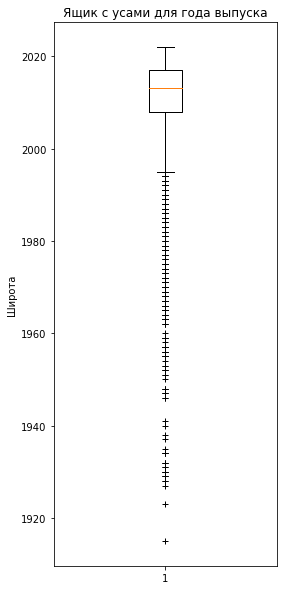

In [44]:
# Выводим "ящик с усами" для года выпуска

plt.figure(figsize=(4, 10))
plt.boxplot(df_clean.year, sym='+')
plt.ylabel('Широта') 
plt.title('Ящик с усами для года выпуска');

In [45]:
# Присваеваем объектам с выбросом по году выпуска значение года по нижней границе интерквартильного размаха

year = min(df_clean.year[(df_clean.year > boundaries_year[0]) & (df_clean.year < boundaries_year[1])]) 
df_clean.loc[outlier_year, 'year'] = year

In [46]:
# Выводим статистики для года выпуска

df_clean.year.describe()

count    9997.000000
mean     2011.733920
std         6.416065
min      1995.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

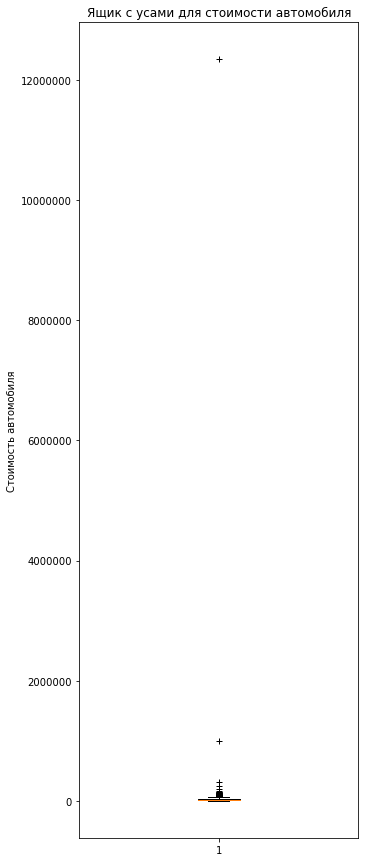

In [47]:
# Определяем выбросы в стоимости

# Выводим "ящик с усами" для стоимости авто

fig, ax = plt.subplots(figsize=(5, 15))
ax.boxplot(df.price, sym='+')
ax.set_ylabel('Стоимость автомобиля')
ax.set_title('Ящик с усами для стоимости автомобиля')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [48]:
# Рассчитываем интерквартильный размах для стоимости авто и количество выбросов

boundaries_price = calculate_outliers(df_clean.price)
outlier_price = (df.price < boundaries_price[0]) | (df.price > boundaries_price[1])
print('Нижняя граница - ', boundaries_price[0], '\nВерхняя граница - ', boundaries_price[1], '\nКоличество выбросов - ', \
      outlier_price.sum())

Нижняя граница -  -22235.0 
Верхняя граница -  58125.0 
Количество выбросов -  215


In [49]:
# Выводим отсортированные по цене строки с выбросами

df_clean[outlier_price].sort_values('price', ascending=False)

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\4000932339.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean[outlier_price].sort_values('price', ascending=False)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,transmission,image_url,description,state,lat,long,posting_date,price_category,date,description_list
6331,7302112231,https://akroncanton.craigslist.org/ctd/d/canto...,akron / canton,https://akroncanton.craigslist.org,12345678,2019,chevrolet,special,gas,100000,...,automatic,https://images.craigslist.org/00F0F_g6k0zWbump...,"WE HAVE MOVED TO 2517 FULTON DRIVE NW CANTON, ...",oh,40.846500,-81.440800,2021-04-05T12:26:23-0400,high,2021-04-05 16:26:23+00:00,"[we, have, moved, to, 2517, fulton, drive, nw,..."
9792,7305237859,https://delaware.craigslist.org/cto/d/delaware...,delaware,https://delaware.craigslist.org,1000000,2022,other,Any make any model,other,283466,...,other,https://images.craigslist.org/00S0S_k3A68PVXRC...,We come to you and give you an easy quick tran...,de,39.572500,-75.595700,2021-04-11T13:51:42-0400,high,2021-04-11 17:51:42+00:00,"[we, come, to, you, and, give, you, an, easy, ..."
5662,7313998757,https://winchester.craigslist.org/ctd/d/manass...,winchester,https://winchester.craigslist.org,304995,2021,porsche,911,gas,22,...,automatic,https://images.craigslist.org/00r0r_gh2TnrNdSu...,2021 PORSCHE 911 Turbo Offered by: Insider...,va,38.762669,-77.461754,2021-04-28T15:49:25-0400,high,2021-04-28 19:49:25+00:00,"[2021, porsche, 911, turbo, offered, by:, insi..."
292,7310897583,https://tucson.craigslist.org/ctd/d/tucson-201...,tucson,https://tucson.craigslist.org,239995,2017,ferrari,488 gtb,gas,6012,...,automatic,https://images.craigslist.org/00t0t_dN5Wr8nfOx...,2017 Ferrari 488 GTB Coupe2017 Ferrari 488 GTB...,az,32.236075,-110.878886,2021-04-22T09:38:59-0700,high,2021-04-22 16:38:59+00:00,"[2017, ferrari, 488, gtb, coupe2017, ferrari, ..."
6121,7315323093,https://daytona.craigslist.org/ctd/d/orlando-2...,daytona beach,https://daytona.craigslist.org,197999,2015,other,Lamborghini Huracan,gas,33875,...,other,https://images.craigslist.org/01717_55Ai9omMq5...,CREDIT AMNESTY! SE HABLA ESPANOL !!OPEN SUNDA...,fl,28.466088,-81.396429,2021-05-01T11:48:44-0400,high,2021-05-01 15:48:44+00:00,"[credit, amnesty!, se, habla, espanol, !!open,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,7313452917,https://austin.craigslist.org/ctd/d/salem-2016...,austin,https://austin.craigslist.org,58670,2016,chevrolet,chevelle,other,16407,...,automatic,https://images.craigslist.org/00000_e7iiMwUVq3...,2016 *** Chevrolet Corvette 2LZ Z06*** ...,tx,44.927304,-123.030322,2021-04-27T13:33:32-0500,high,2021-04-27 18:33:32+00:00,"[2016, ***, chevrolet, corvette, 2lz, z06***, ..."
8163,7307146509,https://lubbock.craigslist.org/ctd/d/brownfiel...,lubbock,https://lubbock.craigslist.org,58600,2019,ford,f-150,gas,29458,...,automatic,https://images.craigslist.org/00E0E_6JF7CBAVf7...,Stanley CDJR Brownfield address: 1706 Lubbo...,tx,33.196047,-102.273565,2021-04-15T08:58:48-0500,high,2021-04-15 13:58:48+00:00,"[stanley, cdjr, brownfield, address:, 1706, lu..."
946,7312212565,https://lasvegas.craigslist.org/cto/d/fresno-d...,las vegas,https://lasvegas.craigslist.org,58500,2013,ram,3500 limited,diesel,57149,...,automatic,https://images.craigslist.org/00o0o_6VEbwgYoL0...,Only 57K Miles! This 3500 RAM Truck has the 6....,nv,36.746400,-119.639700,2021-04-24T20:46:06-0700,high,2021-04-25 03:46:06+00:00,"[only, 57k, miles!, this, 3500, ram, truck, ha..."
6060,7310551940,https://cincinnati.craigslist.org/ctd/d/camp-d...,cincinnati,https://cincinnati.craigslist.org,58500,2019,chevrolet,"silverado 2500hd 4wd crew cab 153.7"" ltz",other,50930,...,automatic,https://images.craigslist.org/01010_ldls5xr3zz...,***Call Us for more information at: 513-453-41...,oh,39.171991,-84.271999,2021-04-21T17:05:31-0400,high,2021-04-21 21:05:31+00:00,"[***call, us, for, more, information, at:, 513..."


In [50]:
# В объявлениях, которые попали в выбросы по цене встречаются как свежие премиальные авто, стоимость которых действительно высокая, 
# так и авто старше 20 лет, бюджетные модели с различным статусом (в т.ч. отремонтированные и в залоге). Значительная часть 
# стоимости в этих объявлениях действительно выбросы, поэтому удаляем эти объявления из выборки

df_clean = df_clean[outlier_price == False]
df_clean.shape

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\3124854345.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[outlier_price == False]


(9782, 21)

In [51]:
# Группируем авто по году выпуска и рассчитываем их количесвто в выборке

stats = df_clean.groupby(['year'], as_index=False)[['id']].count()
stats = stats.rename(columns={'id': 'count'})
stats

,year,count
0,1995,419
1,1996,25
2,1997,45
3,1998,55
4,1999,82
5,2000,78
6,2001,123
7,2002,149
8,2003,185
9,2004,212


In [52]:
# Так как количество авто 2022 г.в. в выборке мало, исключаем их из исследования

df_clean = df_clean[df_clean.year <= 2021]
df_clean.shape

(9780, 21)

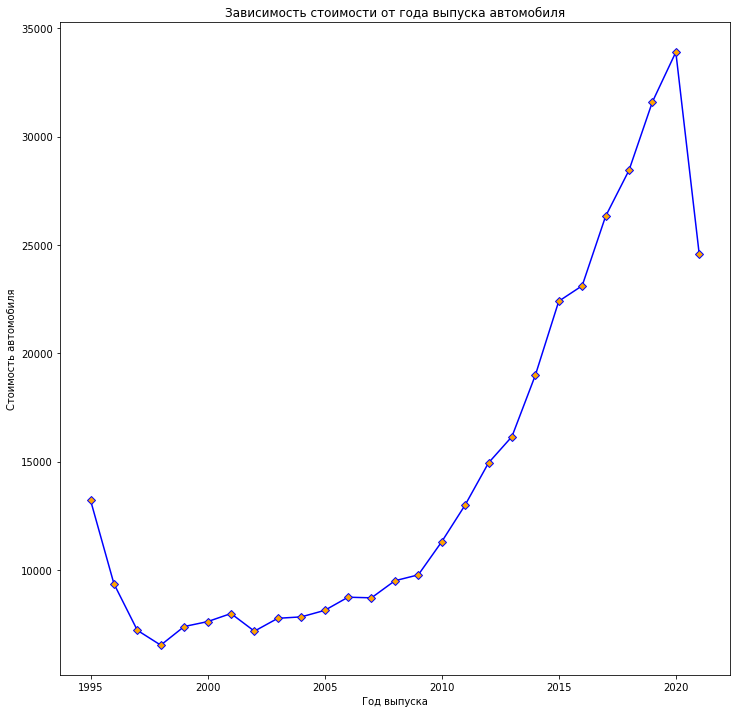

In [53]:
# Рассчитываем среднюю стоимость авто в зависимости от года выпуска и строим график этой зависимости

stats_of_year = df_clean.groupby(['year'], as_index=False).agg({'price': 'mean'})
stats_of_year = stats_of_year.rename(columns={'price': 'mean_price'})

plt.figure(figsize=(12, 12))
plt.plot(stats_of_year['year'], stats_of_year['mean_price'], color='blue', marker='D', markerfacecolor='orange')
plt.xlabel('Год выпуска')
plt.ylabel('Стоимость автомобиля')
plt.title('Зависимость стоимости от года выпуска автомобиля');

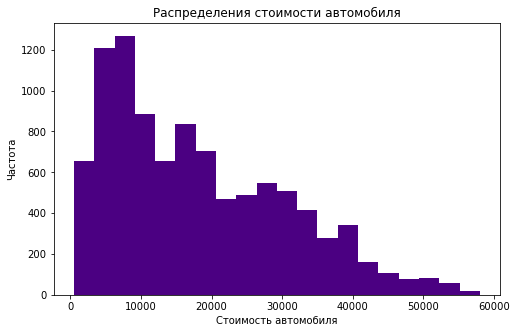

In [54]:
# Строим график распределения стоимости авто 

plt.figure(figsize=(8, 5))
plt.hist(df_clean.price, bins=20, color='indigo')
plt.xlabel('Стоимость автомобиля')
plt.ylabel('Частота')
plt.title('Распределения стоимости автомобиля');

In [55]:
# Определяем выбросы в широте

# Рассчитываем интерквартильный размах для широты  и количество выбросов

boundaries_lat = calculate_outliers(df_clean.lat)
outlier_lat = (df_clean.lat < boundaries_lat[0]) | (df_clean.lat > boundaries_lat[1])
print('Нижняя граница - ', boundaries_lat[0], '\nВерхняя граница - ', boundaries_lat[1], '\nКоличество выбросов - ', \
      outlier_lat.sum())

Нижняя граница -  23.768700000000006 
Верхняя граница -  53.5055 
Количество выбросов -  139


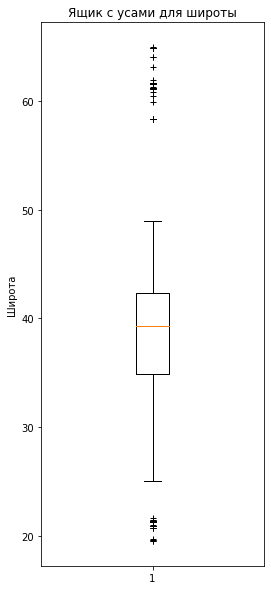

In [56]:
# Выводим "ящик с усами" для стоимости авто

plt.figure(figsize=(4, 10))
plt.boxplot(df_clean.lat, sym='+')
plt.ylabel('Широта') 
plt.title('Ящик с усами для широты');

In [57]:
# Выводим штат для выбросов широты 

list(df_clean[outlier_lat].state.unique())

['hi', 'ak']

In [58]:
# Штаты Гаваи и Аляска действительно имеют широты, значительно отличающиеся от других штатов из-за географического положения
# Данные не являются выбросами

In [59]:
# Определяем выбросы в долготе

# Рассчитываем интерквартильный размах для долготы  и количество выбросов

boundaries_long = calculate_outliers(df_clean.long)
outlier_long = (df_clean.long < boundaries_long[0]) | (df_clean.long > boundaries_long[1])
print('Нижняя граница - ', boundaries_long[0], '\nВерхняя граница - ', boundaries_long[1], '\nКоличество выбросов - ', \
      outlier_long.sum())

Нижняя граница -  -145.75515 
Верхняя граница -  -41.52635000000001 
Количество выбросов -  131


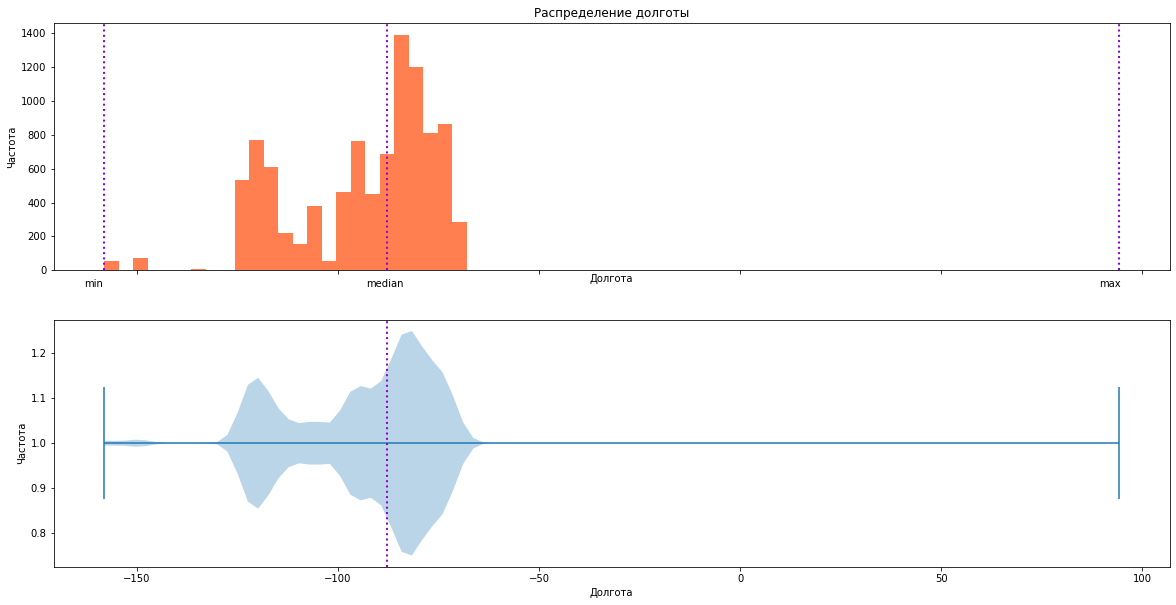

In [60]:
# Строим гистограмму и график скрипки для долготы

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)
ax1.hist(df_clean.long, bins=70, color='coral')
ax1.set_title('Распределение долготы')
ax1.set_xlabel('Долгота')
ax1.set_ylabel('Частота')
ax1.axvline(df_clean.long.median(), color='darkviolet', linestyle='dotted', linewidth=2)
ax1.text(df.long.median() - 5, -100, 'median')
ax1.axvline(df_clean.long.min(), color='darkviolet', linestyle='dotted', linewidth=2)
ax1.text(df_clean.long.min() - 5, -100, 'min')
ax1.axvline(df_clean.long.max(), color='darkviolet', linestyle='dotted', linewidth=2)
ax1.text(df_clean.long.max() - 5, -100, 'max')
ax2.violinplot(df_clean.long, vert=False)
ax2.axvline(df_clean.long.median(), color='darkviolet', linestyle='dotted', linewidth=2)
ax2.set_xlabel('Долгота')
ax2.set_ylabel('Частота');

In [61]:
# Выводим штаты, для которых есть выбросы долготы

df_clean[outlier_long].state.unique()

array(['hi', 'ak', 'mn'], dtype=object)

In [62]:
# Штат Гаваи и штат Аляска действительно имеют долготу, значительно отличающиюся от других штатов из-за географического положения
# Эти данные не являются выбросами. Для штата Миннесота такая долгота является аномальной, сравним долготу из выброса с долготой
# в других объявлениях для этого штата

In [63]:
# Выводим объявление с выбросом по долготе

df_clean[outlier_long].loc[df_clean[outlier_long]['state'] == 'mn']

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,transmission,image_url,description,state,lat,long,posting_date,price_category,date,description_list
8739,7311040095,https://stcloud.craigslist.org/ctd/d/2004-infi...,st cloud,https://stcloud.craigslist.org,3499,2004,infiniti,g35 sedan,gas,185738,...,automatic,https://images.craigslist.org/00e0e_an5Srs55ku...,2004 Infiniti G35 Sedan 4dr Sdn AWD Auto w/Lea...,mn,45.5579,94.1632,2021-04-22T15:34:44-0500,low,2021-04-22 20:34:44+00:00,"[2004, infiniti, g35, sedan, 4dr, sdn, awd, au..."


In [64]:
# Выводим 5 объявлений из штата Миннесота, не содержащих выбросы по долготе

df_clean.loc[df_clean['state'] == 'mn'].head(5)

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,transmission,image_url,description,state,lat,long,posting_date,price_category,date,description_list
56,7314852655,https://stcloud.craigslist.org/ctd/d/alexandri...,st cloud,https://stcloud.craigslist.org,23995,2016,ford,explorer,gas,67696,...,automatic,https://images.craigslist.org/00h0h_cP1IZz5kXo...,CERTIFIED PRE OWNED—XLT PACKAGE—4X4—3.5L TI-VC...,mn,45.833119,-95.387931,2021-04-30T11:18:34-0500,high,2021-04-30 16:18:34+00:00,"[certified, pre, owned—xlt, package—4x4—3.5l, ..."
76,7313940918,https://stcloud.craigslist.org/ctd/d/waite-par...,st cloud,https://stcloud.craigslist.org,25590,2017,jeep,grand cherokee laredo sport,other,31315,...,other,https://images.craigslist.org/00z0z_g2LTZMxb0M...,Carvana is the safer way to buy a car During t...,mn,45.550000,-94.220000,2021-04-28T13:11:20-0500,high,2021-04-28 18:11:20+00:00,"[carvana, is, the, safer, way, to, buy, a, car..."
119,7303485032,https://mankato.craigslist.org/ctd/d/madison-l...,mankato,https://mankato.craigslist.org,17999,2016,buick,enclave,gas,91200,...,manual,https://images.craigslist.org/00N0N_lL5U4qlQ6v...,"Stoufers Auto Sales, Inc address: 50 Walnut...",mn,44.204103,-93.807105,2021-04-07T22:00:22-0500,medium,2021-04-08 03:00:22+00:00,"[stoufers, auto, sales,, inc, address:, 50, wa..."
137,7312980567,https://fargo.craigslist.org/ctd/d/alexandria-...,fargo / moorhead,https://fargo.craigslist.org,12995,2017,volkswagen,passat,gas,110971,...,automatic,https://images.craigslist.org/00W0W_StOdIK1KwO...,CERTIFIED PRE OWNED—TECHNOLOGY PACKAGE—SE PACK...,mn,45.832625,-95.389180,2021-04-26T14:36:53-0500,medium,2021-04-26 19:36:53+00:00,"[certified, pre, owned—technology, package—se,..."
145,7316938454,https://duluth.craigslist.org/cto/d/calumet-83...,duluth / superior,https://duluth.craigslist.org,4000,1995,chevrolet,c10 short box,gas,0,...,automatic,https://images.craigslist.org/00P0P_6I2TfYDHbN...,Arizona project started. new 350 4 bolt main ...,mn,47.394400,-93.246200,2021-05-04T15:55:58-0500,low,2021-05-04 20:55:58+00:00,"[arizona, project, started., new, 350, 4, bolt..."


In [65]:
# Видно, что выброс отличается от долготы для других объявлений из штата Миннесота только знаком. Изменяем знак долготы в выбросе на "-"

df_clean.loc[8739, 'long'] = (-1) * df_clean.loc[8739, 'long']

In [66]:
df_clean[outlier_long].loc[df_clean[outlier_long]['state'] == 'mn']

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,transmission,image_url,description,state,lat,long,posting_date,price_category,date,description_list
8739,7311040095,https://stcloud.craigslist.org/ctd/d/2004-infi...,st cloud,https://stcloud.craigslist.org,3499,2004,infiniti,g35 sedan,gas,185738,...,automatic,https://images.craigslist.org/00e0e_an5Srs55ku...,2004 Infiniti G35 Sedan 4dr Sdn AWD Auto w/Lea...,mn,45.5579,-94.1632,2021-04-22T15:34:44-0500,low,2021-04-22 20:34:44+00:00,"[2004, infiniti, g35, sedan, 4dr, sdn, awd, au..."


In [67]:
# Выводим статистики для показаний одометра

df_clean.odometer.describe()

count      9780.000000
mean      94580.105521
std       62831.970706
min           0.000000
25%       40328.750000
50%       90396.500000
75%      138000.000000
max      283466.000000
Name: odometer, dtype: float64

In [68]:
# Определяем выбросы в показаниях одометра

# Рассчитываем интерквартильный размах для показаний одометра  и количество выбросов

boundaries_odometr = calculate_outliers(df_clean.odometer)
outlier_odometr = (df_clean.odometer < boundaries_odometr[0]) | (df_clean.odometer > boundaries_odometr[1])
print('Нижняя граница - ', boundaries_odometr[0], '\nВерхняя граница - ', boundaries_odometr[1], '\nКоличество выбросов - ', \
      outlier_odometr.sum())

Нижняя граница -  -106178.125 
Верхняя граница -  284506.875 
Количество выбросов -  0


In [69]:
# В показаниях одометра выбросов нет

## Feature engineering

### Feature selection

In [70]:
# Генерируем новую фичу, содержащую количество символов в описании

df_clean['desc_len'] = df_clean.apply(lambda x: len(x.description) , axis=1)
df_clean['desc_len']

0       4482
1        968
2       4286
3       3241
4        538
        ... 
9995    1710
9996     948
9997     909
9998    3644
9999    4483
Name: desc_len, Length: 9780, dtype: int64

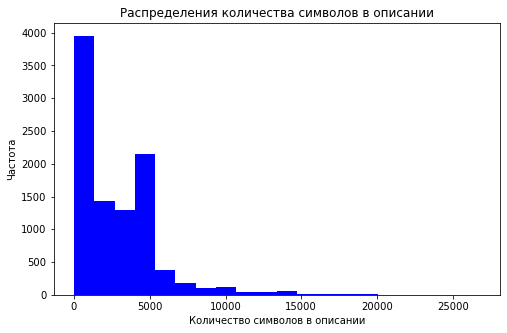

In [71]:
# Строим график распределения количества символов в описании

plt.figure(figsize=(8, 5))
plt.hist(df_clean.desc_len, bins=20, color='blue')
plt.xlabel('Количество символов в описании')
plt.ylabel('Частота')
plt.title('Распределения количества символов в описании');

In [72]:
# Генерируем новую фичу, характеризующую возраст авто

df_clean['age_category'] = df_clean.apply(lambda x: (x.year > 2013 and 'new') or (x.year < 2006 and 'old') or 'average', axis=1)
df_clean.loc[:, ['year', 'age_category']]

,year,age_category
0,2020,new
1,2016,new
2,2017,new
3,2013,average
4,2021,new
...,...,...
9995,2002,old
9996,2008,average
9997,2011,average
9998,2015,new


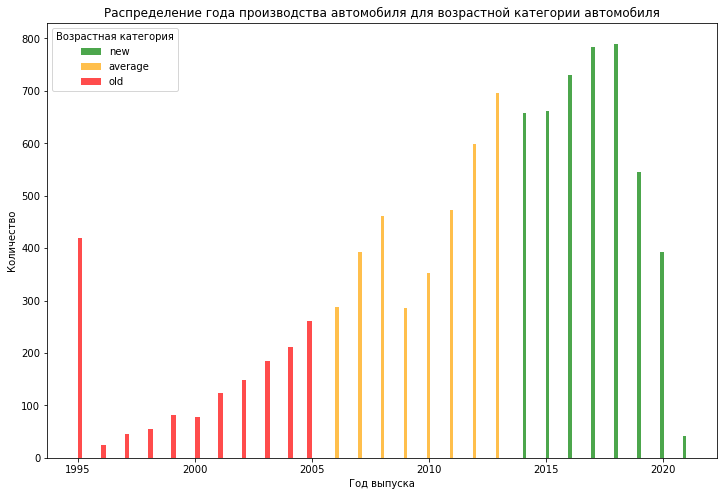

In [73]:
# Выведем график распределения года производства автомобиля для возрастной категории автомобиля

colors = {'new': 'green', 'average': 'orange', 'old': 'red'}

fig, ax = plt.subplots(figsize=(12, 8))
for age_category in colors:
    color = colors[age_category]
    data = df_clean[df_clean['age_category'] == age_category]

    ax.hist(data['year'], bins=50, color=color, alpha=0.7)
    
plt.ylabel('Количество')
plt.xlabel('Год выпуска')
plt.title('Распределение года производства автомобиля для возрастной категории автомобиля')
plt.legend(colors, title="Возрастная категория");

In [74]:
# Генерируем новую фичу, описывающую количество символов в модели авто

df_clean['model_len'] = df_clean.apply(lambda x: len(x.model) , axis=1)
df_clean['model_len'].value_counts()

6      1037
5       843
7       749
8       720
4       676
       ... 
187       1
168       1
58        1
76        1
186       1
Name: model_len, Length: 65, dtype: int64

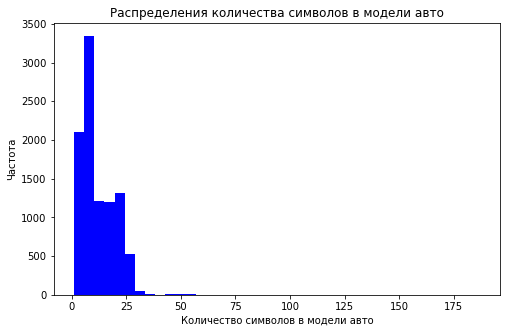

In [75]:
# Строим график распределения количества символов в модели авто

plt.figure(figsize=(8, 5))
plt.hist(df_clean.model_len, bins=40, color='blue')
plt.xlabel('Количество символов в модели авто')
plt.ylabel('Частота')
plt.title('Распределения количества символов в модели авто');

In [76]:
# Генерируем новую фичу, описывающую количество слов в модели авто

df_clean['model_word_count'] = df_clean.apply(lambda x: len(x.model.split(' ')) , axis=1)
df_clean['model_word_count'].value_counts()

1     4362
2     2253
3     1367
4     1187
5      500
6       68
10       8
8        7
11       5
9        5
7        4
13       3
15       3
27       1
21       1
14       1
17       1
24       1
12       1
29       1
22       1
Name: model_word_count, dtype: int64

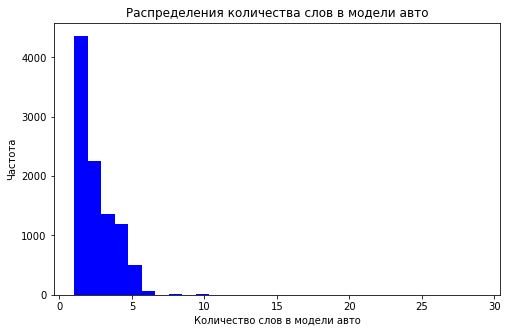

In [77]:
# Строим график распределения количества слов в модели авто

plt.figure(figsize=(8, 5))
plt.hist(df_clean.model_word_count, bins=30, color='blue')
plt.xlabel('Количество слов в модели авто')
plt.ylabel('Частота')
plt.title('Распределения количества слов в модели авто');

In [78]:
# Рассчитываем количесттво уникальных значений в столбце с названием модели

df_clean.model.nunique()

3400

In [79]:
# Генерируем новую фичу, в которой содержится первое слово из названия модели, чтобы сократить количество уникальных значений

df_clean['short_model'] = df_clean.model.apply(lambda x: x.lower().split(' ')[0])
print(df_clean.short_model)
print('\nКоличество уникальных значений:', df_clean.short_model.nunique())

0           2500
1       explorer
2           golf
3           rav4
4         altima
          ...   
9995        rav4
9996    wrangler
9997          a3
9998     cayenne
9999        1500
Name: short_model, Length: 9780, dtype: object

Количество уникальных значений: 934


In [80]:
df_clean.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,long,posting_date,price_category,date,description_list,desc_len,age_category,model_len,model_word_count,short_model
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00,"[carvana, is, the, safer, way, to, buy, a, car...",4482,new,22,5,2500
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,"[***call, us, for, more, information, at:, 201...",968,new,20,4,explorer
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00,"[carvana, is, the, safer, way, to, buy, a, car...",4286,new,16,3,golf
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00,"[2013, toyota, rav4, xle, 4dr, suv, offered, b...",3241,average,4,1,rav4
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,"[2021, nissan, altima, sv, with, only, 8, k, m...",538,new,6,1,altima


### Data transformation

In [81]:
# Преобразование категориальных переменных

# Выводим количество уникальных значений для категориальных переменных

df_clean[['region',  'manufacturer', 'fuel', 'title_status', 'transmission', 'state', 'age_category', 'short_model']].nunique()

region          393
manufacturer     40
fuel              5
title_status      6
transmission      4
state            51
age_category      3
short_model     934
dtype: int64

In [82]:
print(df_clean.columns.tolist())

['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date', 'price_category', 'date', 'description_list', 'desc_len', 'age_category', 'model_len', 'model_word_count', 'short_model']


In [83]:
# Преобразуем категориальные переменные с помощью OneHotEncoder

data = df_clean[['region',  'manufacturer', 'fuel', 'title_status', 'transmission', 'state', 'age_category', 'short_model']]
ohe = OneHotEncoder(sparse=False)
ohe.fit(data)
ohe_data = ohe.transform(data)
ohe.get_feature_names_out()
df_clean[ohe.get_feature_names_out()] = ohe_data
print(ohe_data)
ohe_data.shape

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[ohe.get_feature_names_out()] = ohe_data
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\2998571555.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

(9780, 1436)

In [84]:
# Преобразование признаков дат

df_clean.date = pd.to_datetime(df_clean.date, utc=True)
df_clean['month'] = df_clean.date.dt.month
df_clean['dayofweek'] = df_clean.date.dt.weekday
df_clean['diff_years'] = df_clean.date.dt.year - df_clean.year

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\4232034858.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['month'] = df_clean.date.dt.month
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\4232034858.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['dayofweek'] = df_clean.date.dt.weekday
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_11612\4232034858.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [85]:
# Стандартизация количественных переменных

quant_list = ['year', 'odometer', 'lat', 'long', 'desc_len', 'model_len', 'model_word_count', 'month', 'dayofweek', 'diff_years']
data_quant = df_clean[quant_list]
std_scaler = StandardScaler()
std_scaler.fit(data_quant)
std_scaled = std_scaler.transform(data_quant)
std_quant_list = ['std_scaled_' + elem for elem in quant_list]
df_clean[std_quant_list] = std_scaled
df_clean.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,std_scaled_year,std_scaled_odometer,std_scaled_lat,std_scaled_long,std_scaled_desc_len,std_scaled_model_len,std_scaled_model_word_count,std_scaled_month,std_scaled_dayofweek,std_scaled_diff_years
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,1.310383,-1.068589,-0.615576,0.484449,0.618836,1.173715,1.925143,-0.613908,1.117518,-1.310383
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.684471,-0.550021,0.393265,1.115330,-0.654611,0.941695,1.246929,1.628909,-1.373099,-0.684471
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.840949,-1.281771,-0.839831,0.531714,0.547807,0.477656,0.568715,-0.613908,-0.376852,-0.840949
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.215037,0.361473,-0.500724,0.856316,0.169107,-0.914460,-0.787713,-0.613908,1.117518,-0.215037
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,1.466861,-1.378033,0.364024,1.140832,-0.810439,-0.682441,-0.787713,1.628909,-1.373099,-1.466861


In [86]:
# Удаление неинформативных столбцов и формирование финального датасета

print(df_clean.columns.tolist())

['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date', 'price_category', 'date', 'description_list', 'desc_len', 'age_category', 'model_len', 'model_word_count', 'short_model', 'region_SF bay area', 'region_abilene', 'region_akron / canton', 'region_albany', 'region_albuquerque', 'region_altoona-johnstown', 'region_amarillo', 'region_ames', 'region_anchorage / mat-su', 'region_ann arbor', 'region_annapolis', 'region_appleton-oshkosh-FDL', 'region_asheville', 'region_ashtabula', 'region_athens', 'region_atlanta', 'region_auburn', 'region_augusta', 'region_austin', 'region_bakersfield', 'region_baltimore', 'region_baton rouge', 'region_battle creek', 'region_beaumont / port arthur', 'region_bellingham', 'region_bemidji', 'region_bend', 'region_billings', 'region_binghamton', 'region_birmingham', 'region_bismarck', 'region_bloomington', 'region_b

In [87]:
# Удаляем неинформативные колонки и первоначальные признаки до преобразований

columns_for_drop = ['id', 'price', 'year', 'url', 'region', 'region_url', 'manufacturer',
                    'model', 'fuel', 'odometer', 'title_status', 'transmission',
                    'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
                    'desc_len', 'age_category', 'model_len', 'model_word_count',
                    'short_model', 'date', 'description_list', 'month', 'dayofweek', 'diff_years']
df_prepared = df_clean.drop(columns=columns_for_drop)
print(df_prepared.columns.tolist())

df_prepared.to_csv('data/vehicles_dataset_prepared.csv', index=False)

['price_category', 'region_SF bay area', 'region_abilene', 'region_akron / canton', 'region_albany', 'region_albuquerque', 'region_altoona-johnstown', 'region_amarillo', 'region_ames', 'region_anchorage / mat-su', 'region_ann arbor', 'region_annapolis', 'region_appleton-oshkosh-FDL', 'region_asheville', 'region_ashtabula', 'region_athens', 'region_atlanta', 'region_auburn', 'region_augusta', 'region_austin', 'region_bakersfield', 'region_baltimore', 'region_baton rouge', 'region_battle creek', 'region_beaumont / port arthur', 'region_bellingham', 'region_bemidji', 'region_bend', 'region_billings', 'region_binghamton', 'region_birmingham', 'region_bismarck', 'region_bloomington', 'region_bloomington-normal', 'region_boise', 'region_boone', 'region_boston', 'region_boulder', 'region_bowling green', 'region_bozeman', 'region_brainerd', 'region_brownsville', 'region_brunswick', 'region_buffalo', 'region_butte', 'region_cape cod / islands', 'region_catskills', 'region_cedar rapids', 'region

## Modeling

In [88]:
# Инициализация фичей и целевой переменной. Train/test split

x = df_prepared.drop(['price_category'], axis=1)
y = df_prepared['price_category']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

In [89]:
# Логистическая регрессия

logreg = LogisticRegression(C=2, random_state=42, max_iter=500)

In [90]:
# Случайный лес

rf_clf = RandomForestClassifier(random_state=42, bootstrap=False, max_features='log2', min_samples_split=5, n_estimators=500)

In [91]:
# Многослойный персептрон

mlp = MLPClassifier(random_state=42, max_iter=500, solver = 'lbfgs', hidden_layer_sizes=(100,30), activation = 'tanh')

In [92]:
# Оценка каждой из моделей с помощью кросс-валидации на тренировочной выборке

for model in [logreg, rf_clf, mlp]:
    cv_score = cross_val_score(model, train_x, train_y, cv=7)
    print(cv_score.mean(), cv_score.std())

0.7655565293602103 0.013339702082186246
0.7699386503067486 0.017030866238857113
0.7738825591586328 0.012468312785786329


In [93]:
# Рассчитываем метрику на тестовой выборке для многослойного персептрона - лучшей модели по результату кросс-валидации

mlp.fit(train_x, train_y)
mlp_pred = mlp.predict(test_x)
print('Accuracy test = ', accuracy_score(test_y, mlp_pred))

Accuracy test =  0.7747102931152011


In [ ]:
# Значение метрики accuracy на тестовой выборке незначительно отличается и даже немного выше, чем на тренировочной определенная
# с помощью кросс-валидации(вероятно за счет большего размера выборки). Модель не переобучилась.

## Results

In [ ]:
# По результатам моделирования с помощью кросс-валидации лучший результат показала модель многослойного персептрона

In [ ]:
# Обучение модели на всем датасете

mlp.fit(x, y)

In [107]:
filename = 'vehicles_model.pickle'

with open(filename, 'wb') as file:
    pickle.dump(mlp, file)